# Competition
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a [quick tutorial](https://www.kaggle.com/philculliton/nlp-getting-started-tutorial) to get you up and running.

### Judge Metric.
Submissions are evaluated using [F1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) between the predicted and expected answers.

\begin{equation*}
F_1 =  2 * {\frac{precision * recall}{precision + recall}}
\end{equation*}

where:
\begin{equation*}
precision = {\frac{TP}{TP + FP}}
\end{equation*}
and:
\begin{equation*}
recall = {\frac{TP}{TP + FN}}
\end{equation*}

* True Positive [TP] = your prediction is 1, and the ground truth is also 1.
* False Positive [FP] = your prediction is 1, and the ground truth is 0.
* False Negative [FN] = your prediction is 0, and the ground truth is 1.

### What files do I need?
You'll need train.csv, test.csv and sample_submission.csv.

### What should I expect the data format to be?
Each sample in the train and test set has the following information:
* The text of a tweet.
* A keyword from that tweet (although this may be blank!).
* The location the tweet was sent from (may also be blank).

### What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

### Files
* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format

### Columns
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
%cd ..
%cd /gdrive/My\ Drive/Colab\ Notebooks/Real\ or\ Not\?\ NLP\ with\ Disaster\ Tweets

/
/gdrive/My Drive/Colab Notebooks/Real or Not? NLP with Disaster Tweets


### Importing packages.

In [0]:
# numpy and pandas for data manipulation
import math
import nltk
from   nltk              import bigrams,trigrams
from   nltk.collocations import *
from   nltk.corpus       import stopwords
from   nltk.metrics      import BigramAssocMeasures
import numpy as np
import os
import pandas as pd
import re
import spacy
import string
from string import punctuation
import time

# sklearn preprocessing
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Reading Data

In [5]:
train_data = pd.read_csv('data/train.csv')
train_data.shape

(7613, 5)

In [6]:
test_data = pd.read_csv('data/test.csv')
test_data.shape

(3263, 4)

In [0]:
#Function to create a regular expression rule using wods
def convert_to_rule(word1, word2):
    return re.compile(str('(.*)('+word1+".*"+word2+')'))

### Preprocessing and normalize text data function

In [0]:
def clean(text):
  # Remove wierd characters
  try:
    text = str(text.encode('ascii', 'ignore'))
  except:
    text = 'No Information'

  # Remove links/websites from text
  text= " "+re.sub(r'www[.][\S]*[.].{3}','',re.sub(r'https?:\/\/[\S]*[.].{3}','',text))+" "
  
  # Calculate Emoticon score:
  # 1. Calculate the difference between the number of positive and negative emoticons in the text
  emoticon_score = len([emoticon for emoticon in pos_emoticons if emoticon in text]+[symbol for symbol in pos_symbols if symbol in text.lower()]) - len([emoticon for emoticon in neg_emoticons if emoticon in text]+[symbol for symbol in neg_symbols if symbol in text.lower()])

  # 2. Give a score to the text from -2 to +2 depending apon the above number
  if emoticon_score > 3: 
    emoticon_score = 2
  elif emoticon_score > 0:
    emoticon_score = 1
  elif emoticon_score == 0:
    emoticon_score = 0
  elif emoticon_score >- 3: 
    emoticon_score =-1
  else:
    emoticon_score =-2
  # Remove numbers from text
  text = re.sub(r'[0-9]*','',text.lower())
  text = re.sub(r'[0-9]+[0-9.,]+[0-9]+','',text)

  # Replace generic phrases by corresponding normalised phrases
  for p, phrase in enumerate(generic_phrases):
    if phrase in text:
      text = text.replace(phrase, normalised_phrases[p])
  # Remove inverted commas, brackets and other punctuation marks, and multiple consecutive exclamation marks, question marks, commas, full stops, etc
  text = re.sub(name,' @', re.sub(eclm,' ! ',re.sub(qstn,' ? ',re.sub(coma,' , ',re.sub(full,' . ',re.sub(rand,' ',text))))))
  text = re.sub('\/',' or ',text)
  text = re.sub('\[','',text)
  text = re.sub('\]','',text)
  text = re.sub(nums,'',text)
  text = re.sub(dash,' ', text)
  text = text.replace("'",'')
  
  # Return clean text and calculated emoticon score
  return text, emoticon_score


### Sentiment Analysis
The first thing that we would want to add for our dataset are the sentiment score (if is not neutral) in every tweet, the sentiment words if there is and the an emoticon score in case the user used an emoticon on the tweet.


In [0]:
# Function to retrive sentiment score of a given word/bigram/phrase from sentiment dictionary
def sentiment_score(phrase):
  if phrase in pos_words:
    return np.mean(list(positive_keys[positive_keys['Words']  == phrase]['Co_Word_score']))
  elif phrase in neg_words:
    return np.mean(list(negative_keys[negative_keys['Words']  == phrase]['Co_Word_score']))
  elif phrase in pos_bigrm:
    return np.mean(list(positive_keys[positive_keys['Bigrams']== phrase]['Co_Bigram_score']))
  elif phrase in neg_bigrm: 
    return np.mean(list(negative_keys[negative_keys['Bigrams']== phrase]['Co_Bigram_score']))
  else: 
    return 0

# Function to combine scores of the same polarity
def combine(score_list):
    max_score = max(score_list)
    return (max_score + ((sum(score_list) - max_score)/(math.pow(2, max_score))))

In [0]:
# Function to roll-up word/phrase leve scores to give overall text score
def aggregate_scores(data):
    sent_list = list(set(list(data['sent_no'])))
    net_scores= [0]*len(sent_list)
    # Iterate through every sentence in the text
    for sent_no in sent_list:
        phrase = data[data['sent_no'] == sent_no]
        # Extract individual scores for the sentence in a list
        score_list = list(phrase['word_score'])                                   
        # Extract positive scores
        pos = [s for s in score_list if s>0]
        # Extract negative scores
        neg = [s for s in score_list if s<0]
        pos_score, neg_score = 0, 0
        # Combine positive scores to get net positive score for the sentence
        if len(pos) > 0:
          pos_score = combine(pos)                                 
        # Combine negative scores to get net negative score for the sentence
        if len(neg) > 0:
          neg_score = (-combine([-s for s in neg]))                  
        # Add the above two to get overall sentence score
        net_scores[sent_no-1] = pos_score + neg_score                               
    # Take average of all sentence scores to get overall text score
    overall_score = round(np.mean([s for s in net_scores if s!=0]), 2)             
    if np.isnan(overall_score): 
      return 0
    else:
      return overall_score


In [0]:
# Function to identify features, sentiemnt words and corresponding scores
def idenify_features_and_describers(data):
  # Iterate through every word in the text
  for w in data.index:
    word = data['word'][w]
    if word in negation_words: 
      data['is_describer'][w] = 'REFER TO NEXT'

    # Identifying sentiment words and scores
    # 1. Word level
    # Check if the word is in the list of positive words or negative words
    if word in (pos_words + neg_words):  
      # Retrive the sentiment score of the word
      data['word_score'][w] = sentiment_score(word)             
      # Add the word to the list of sentiment words
      data['is_describer'][w] = word                              

    # 2. Bigram level
    if w > 0:
      # create bigram from word and preceeding word
      bigram = data['word'][w-1] +' '+ word
      # Check if the bigram is in the list of positive bigrams or negative bigrams
      if bigram in (pos_bigrm + neg_bigrm):
        # Retrive the sentiment score of the bigram
        data['word_score'][w] = sentiment_score(bigram)
        data['word_score'][w-1] = 0
        # Add the bigram to the list of sentiment words
        data['is_describer'][w]  = bigram
        data['is_describer'][w-1]= 'REFER TO NEXT'

    # Identifying features
    # Logic used: Word is a feature if
    # * it is a noun
    # * is not in the list of positive/negative words
    # * is not a common english word like 'the','of' etc
    # * has a more than 3 characters
    if all([data['pos'][w] in ('NN','NNP','NNS','NNPS'), word not in pos_words + neg_words, word not in stopwords.words('english'), len(word) > 3]):
      if w == 0:
        data['is_entity'][w] = word
      elif data['is_entity'][w-1] not in ['','REFER TO NEXT']:
        data['is_entity'][w] = data['is_entity'][w-1]+' '+word
        data['is_entity'][w-1] = 'REFER TO NEXT'
      else:
        data['is_entity'][w] = word
  return data

In [0]:
# Function to break the text into sentences
def identify_phrases(data):
  # Iterate through every word in the text
  for r in data.index:
    if data['pos'][r] == '.':
      # If word is a symbol like '.','?','!' then the succeeding text is treated as a new sentence
      data['sent_no'][r+1:] = data['sent_no'][r]+1
  return data

In [0]:
# Function to modify word level scores based on surounding words
def apply_surr_words_effect(data):
  # Iterate through every word in the text
  for w in data.index:
    word = data['word'][w]
    # Add the previous 3 words to the current word to create a phrase, for phrase level analysis
    phrase = ' '.join(data['word'][max(0,w-3):w+1])
    # Define the number of preceeding words to be considered while checking effect of negation words (currently set to 3)
    pre_words_consider_for_negation = 3
    preceding_start = max(0,w-pre_words_consider_for_negation)
    # Initialize a flag to check if the text is preceeded by a negation word
    negated=0
    # Initialize a flag to check if the text is preceeded by an intensity word
    intense=0

    # Applying exception rules
    # Logic:    If text contains any of the exceptions (specified in the sentiment dictionary) then its score becomes the score of that exception phrase
    # Example:  If text contains the word 'cheap' along with the word 'price', its sentiment score becomes positive instead of negative
    if not any([symbol for symbol in ['.','?','!'] if symbol in phrase]):
      for rule, score in exeption_rules:
        if rule.match(phrase) and phrase == rule.match(phrase).group(0):
          data['word_score'][w] = score
          data['is_describer'][w] = rule.match(phrase).group(2)
          for p_w in range((w-len(data['is_describer'][w].split())+1), w):
            data['is_describer'][p_w] = 'REFER TO NEXT'
          preceding_start = max(w+1-len(data['is_describer'][w].split())-pre_words_consider_for_negation,0)

    if data['word_score'][w]!=0:
      # Applying negation rules
      # Logic:    If there is a word like not/never/dont in the preceeding 3 words (this value is defined above), the score is negated
      # Example: 'not good' is negative
      preceding_text = ' '+'  '.join(data['word'][preceding_start:w+1])+' '
      if not any([n+' ' in data['is_describer'][w] for n in negation_words]):
        for negator in negation_words:
          negation_rule = convert_to_rule(' '+negator+' ',' '+word+' ')
          if negation_rule.match(preceding_text) and preceding_text==negation_rule.match(preceding_text).group(0):
            if list(set(data['word_score'][w-len(negation_rule.match(preceding_text).group(2).split())+1:w]))==[0]: 
              negated = 1
        if data['word_score'][w]>0 and negated==0:
          for negator in pos_negation_words:
            negation_rule=convert_to_rule(' '+negator+' ',' '+word+' ')
            if negation_rule.match(preceding_text) and preceding_text==negation_rule.match(preceding_text).group(0):
              if list(set(data['word_score'][w-len(negation_rule.match(preceding_text).group(2).split())+1:w]))==[0]: 
                negated = 1

      # Applying intensity rules
      # Logic:    If there is a word like very/soo/highly in the preceeding 3 words (this value is defined above), the score is amplified
      # Example:  'very good' is more positive than 'good'
      if not any([n+' ' in data['is_describer'][w] for n in intensity_words]):
        for intensifier in intensity_words:
          intensity_rule=convert_to_rule(' '+intensifier+' ',' '+word+' ')
          if intensity_rule.match(preceding_text) and preceding_text==intensity_rule.match(preceding_text).group(0):
            if list(set(data['word_score'][w-len(intensity_rule.match(preceding_text).group(2).split())+1:w])) == [0]:
              intense=1
      if w > 0 and data['word'][w-1] in ['pretty','quite'] and 'very' not in data['is_describer'][w]:
        data['word_score'][w-1] = 0
        data['is_describer'][w-1] = 'REFER TO NEXT'
        intense = 1

      if negated == 1 and intense == 1:
        data['word_score'][w] = -data['word_score'][w] + (int(data['word_score'][w]>0) - int(data['word_score'][w]<0))
        data['is_describer'][w] = 'not very '+ data['is_describer'][w]
      elif negated == 1 and intense == 0:
        data['word_score'][w] = -data['word_score'][w]
        data['is_describer'][w] = 'not '+data['is_describer'][w]
      elif negated==0 and intense==1:
        data['word_score'][w] = data['word_score'][w]+(int(data['word_score'][w]>0)-int(data['word_score'][w]<0))
        data['is_describer'][w] = 'very '+data['is_describer'][w]
      #  Check if word is preceeded by an adverb (defined as a word ending in 'ly') and if the sentiment of the word and the adverb are opposite, ignore the sentiment of the adverb
      if w-1 in data.index:
        if  data['word'][w-1][-2:] == 'ly' and data['word_score'][w-1]*data['word_score'][w] < 0:
          data['word_score'][w-1]  = 0
        if data['word'][w-1] in ['nothing']:
          if data['word_score'][w] < 0:
            data['word_score'][w]= 1
          if data['word_score'][w] > 0:
            data['word_score'][w]=-1
          data['is_describer'][w]='not '+data['is_describer'][w]

    # Handling effect of 'yet' and'but'
    # Logic:   If there are 2 sentiment words with the word yet/but between them, sentiment of the former is not important
    # Example: 'tasty but ugly' is negative, 'ugly yet tasty' is positive
    if word in ['yet','but']:
      #  Check if any of the 3 words after the word but/yet have a non-zero sentiment, and if present, extract its score
      suc_score=0
      if w + 1 in data.index and data['word_score'][w+1] != 0:
        suc_score=data['word_score'][w+1]
      elif w + 2 in data.index and data['word_score'][w+2] !=0:
        suc_score=data['word_score'][w+2]
      elif w + 3 in data.index and data['word_score'][w+3] != 0:
        suc_score=data['word_score'][w+3]
      # Check if any of the 3 words before the worc but/yet has a sentiment opposite to that of the above found word, and if present, make its score zero
      if suc_score!=0:
        if   w-1 in data.index and data['word_score'][w-1]*suc_score<0:
          data['word_score'][w-1]=0
        elif w-2 in data.index and data['word_score'][w-2]*suc_score<0:
          data['word_score'][w-2]=0
        elif w-3 in data.index and data['word_score'][w-3]*suc_score<0:
          data['word_score'][w-3]=0

    return data

In [0]:
# Function to calculate the sentiment score of the text
def text_sentiments(survey):
  # Remove unnessecary punctuations, numbers, website links etc to get clean simple text
  text, emoticon_score = clean(survey)
  # Extract words fromt the text
  tokens = nltk.word_tokenize(text)
  # Create a table to store metadata about all the words like their part of speech, sentiment score etc
  data = pd.DataFrame({'word':tokens,'pos':[tag for (word,tag) in nltk.pos_tag(tokens)]}) 
  data['word_score'], data['is_entity'], data['is_describer'], data['sent_no'] = 0, '', '', 1
  # Score the words/phrases
  data = apply_surr_words_effect(identify_phrases(idenify_features_and_describers(data))) 
  # Combine above scores to get overall text score
  overall_score = aggregate_scores(data)
  # Extract the words/phrases with non-zero sentiment scores
  senti_word_data=data[data['word_score']!=0]
  # Combine the above words/phrases into a single string
  sentiment_words=','.join([w for w in list(set(list(senti_word_data['is_describer']))) if w not in ['REFER TO NEXT','']])
  return overall_score, sentiment_words, emoticon_score

#### Load sentiment dictionary

Load sentiment dictionary from General_Sentiment_Lexicon_v5.xlsx and create a list of sentiment related words, bigrams, emoticons, symbols and other phrases.

In [0]:
# Define constants:

# Load the sentiement dictionary from excel file
sentiment_dictionary = 'General_Sentiment_Lexicon_v5.xlsx'
positive_keys        = pd.read_excel(sentiment_dictionary,'Positive Phrases')
negative_keys        = pd.read_excel(sentiment_dictionary,'Negative Phrases')
amplifier_keys       = pd.read_excel(sentiment_dictionary,'Negators and Amplifiers')
standard_keys        = pd.read_excel(sentiment_dictionary,'Standardization Rules')
exeption_keys        = pd.read_excel(sentiment_dictionary,'Exeption Rules')

# Create lists for sentiment related words,bigrams,emoticons,symbols and other phrases
pos_emoticons        = [str(e) for e in positive_keys['Emoticons']   if not str(e)=='nan']
neg_emoticons        = [str(e) for e in negative_keys['Emoticons']   if not str(e)=='nan']
pos_symbols          = [str(s) for s in positive_keys['Symbols']     if not str(s)=='nan']
neg_symbols          = [str(s) for s in negative_keys['Symbols']     if not str(s)=='nan']
pos_words            = [str(w) for w in positive_keys['Words']       if not str(w)=='nan']
neg_words            = [str(w) for w in negative_keys['Words']       if not str(w)=='nan']
pos_bigrm            = [str(w) for w in positive_keys['Bigrams']     if not str(w)=='nan']
neg_bigrm            = [str(w) for w in negative_keys['Bigrams']     if not str(w)=='nan']
intensity_words      = [str(w) for w in amplifier_keys['Amplifiers'] if not str(w)=='nan']
negation_words       = [str(w) for w in amplifier_keys['Negators']   if not str(w)=='nan']
pos_negation_words   = [str(w) for w in amplifier_keys['Positive only negators']   if not str(w)=='nan']
normalised_phrases   = [str(w).replace('_',' ').lower() for w in standard_keys['Normalised_phrase']]
generic_phrases      = [str(w).replace('_',' ').lower() for w in standard_keys['Phrase']]
StopWords            = list(stopwords.words('english'))

In [0]:
# Map the exception rules to their corresponding sentiment sores
exeption_rules=[]
for k in exeption_keys.index:
  if str(exeption_keys['Preceeding'][k])!='nan':
    for pre in exeption_keys['Preceeding'][k].split(','):
      exeption_rules.append((convert_to_rule(pre,exeption_keys['Word'][k]),exeption_keys['Sentiment'][k]))
  if str(exeption_keys['Suceeding'][k])!='nan':
    for suc in exeption_keys['Suceeding'][k].split(',') :
      exeption_rules.append((convert_to_rule(exeption_keys['Word'][k],suc),exeption_keys['Sentiment'][k]))
  if str(exeption_keys['Around'][k])!='nan':
    for sur in exeption_keys['Around'][k].split(','):
      exeption_rules.append((convert_to_rule(sur,exeption_keys['Word'][k]),exeption_keys['Sentiment'][k]))
      exeption_rules.append((convert_to_rule(exeption_keys['Word'][k],sur),exeption_keys['Sentiment'][k]))

In [0]:
# Define regur expressions for punctuations and symbols
rand    = re.compile('[~`|#$)%^}&{(*<>"_+:;]')
full    = re.compile('[.]+')
coma    = re.compile('[,]+')
qstn    = re.compile('[?]+')
eclm    = re.compile('[!]+')
name    = re.compile('[@]+')
dash    = re.compile('[-]+')
nums    = re.compile('\S*[\d]\S*')
periods = re.compile('[!]+|[.]+|[?]+')

#### Add Sentiment Analysis Features

In [0]:
# Lets create a copy of both datasets just to have a variable were the data is not being manipulated
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

We add this three features to the training set and the testing set.


In [19]:
train_data_copy['Text sentiment'] = 0.0
train_data_copy['Sentiment words'] = ''
train_data_copy['Emoticon sentiment'] = 0

for i in train_data_copy.index:
  train_data_copy['Text sentiment'][i], train_data_copy['Sentiment words'][i], train_data_copy['Emoticon sentiment'][i] = text_sentiments(train_data_copy['text'][i])
train_data_copy.head()

,id,keyword,location,text,target,Text sentiment,Sentiment words,Emoticon sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.0,,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.0,,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.0,,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.0,,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,-2.0,smoke,0


In [20]:
test_data_copy['Text sentiment'] = 0.0
test_data_copy['Sentiment words'] = ''
test_data_copy['Emoticon sentiment'] = 0

for i in test_data_copy.index:
  test_data_copy['Text sentiment'][i], test_data_copy['Sentiment words'][i], test_data_copy['Emoticon sentiment'][i] = text_sentiments(test_data_copy['text'][i])
test_data_copy.head()

,id,keyword,location,text,Text sentiment,Sentiment words,Emoticon sentiment
0,0,NaN,NaN,Just happened a terrible car crash,-3.25,"crash,terrible",0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",2.00,safe,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",-1.00,fleeing,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.00,,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,-2.00,kills,0


### Exploratory Data Analysis

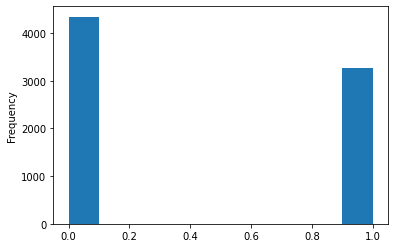

In [21]:
# target balance.
train_data_copy['target'].astype(int).plot.hist()

#### Encoding Categorical Variables
Before we go any further, we need to deal with pesky categorical variables like the ones in the 'Sentiment Words' column. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

**Label encoding:** assign each unique category in a categorical variable with an integer. No new columns are created.

Problem: The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want.

**One-hot encoding:** create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

Problem: The number of features can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by PCA or other dimensionality reduction methods to reduce the number of dimensions.

For this case in particular, we would use One-Hot encoding.

In [22]:
print('Number of each type of column')
print(train_data_copy.dtypes.value_counts())
print('\nNumber of unique classes in each object column')
print(train_data_copy.select_dtypes('object').apply(pd.Series.nunique, axis = 0))

Number of each type of column
object     4
int64      3
float64    1
dtype: int64

Number of unique classes in each object column
keyword             221
location           3341
text               7503
Sentiment words    2985
dtype: int64


In [0]:
#@title Function that separates the sentiment words into columns
def separate_list_2_col(df, column_name, string_column=True, separator=',', remove_column=False):
  if string_column:
    df[column_name] = df[column_name].apply(lambda x : x.split(separator))
  df[column_name].apply(lambda x : x.sort())
  max_length = df[column_name].map(lambda x: len(x)).max()
  
  column_names = []
  for i in range(max_length):
    new_column_name = column_name + '_' + str(i)
    column_names.append(new_column_name)
    df[new_column_name] = ''
  
  for i in df[column_name].index:
    for index, text in enumerate(df.iloc[i][column_name]):
      df.at[i, column_names[index]] = text
  
  if remove_column:
    df = df.drop(labels=column_name, axis=1)
  
  return df

In [0]:
train_data_copy = separate_list_2_col(train_data_copy, 'Sentiment words', remove_column=True)

In [0]:
test_data_copy = separate_list_2_col(test_data_copy, 'Sentiment words', remove_column=True)

#### Normalizing Location
We know that people can change the location in tweet, they can leave it in blank and even put a string that it's not a location at all.

Let's try to normalize this data

In [0]:
nlp = spacy.load('en')
def what_location(this_location):
  this_location, _ = clean(this_location)
  locations_replace = []
  try:
    for X in nlp(this_location).ents:
      if X.label_ == 'GPE':
        locations_replace.append(X.text)
  except:
    pass
  return locations_replace

def is_it_a_real_location(df, column_name, remove_column=False):
  # progress_apply
  df[column_name] = df[column_name].apply(lambda x : what_location(x))
  df = separate_list_2_col(df, column_name, string_column=False, remove_column=remove_column)
  return df
  

Apply this change into the train and testing datasets.

In [27]:
train_data_copy = is_it_a_real_location(train_data_copy, column_name='location', remove_column=True)
train_data_copy.head()

,id,keyword,text,target,Text sentiment,Emoticon sentiment,Sentiment words_0,Sentiment words_1,Sentiment words_2,Sentiment words_3,Sentiment words_4,Sentiment words_5,Sentiment words_6,Sentiment words_7,Sentiment words_8,location_0,location_1,location_2,location_3
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.0,0,,,,,,,,,,,,,
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,0.0,0,,,,,,,,,,,,,
2,5,NaN,All residents asked to 'shelter in place' are ...,1,0.0,0,,,,,,,,,,,,,
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,0.0,0,,,,,,,,,,,,,
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,-2.0,0,smoke,,,,,,,,,,,,


In [28]:
test_data_copy = is_it_a_real_location(test_data_copy, column_name='location', remove_column=True)
test_data_copy.head()

,id,keyword,text,Text sentiment,Emoticon sentiment,Sentiment words_0,Sentiment words_1,Sentiment words_2,Sentiment words_3,Sentiment words_4,Sentiment words_5,Sentiment words_6,location_0,location_1,location_2
0,0,NaN,Just happened a terrible car crash,-3.25,0,crash,terrible,,,,,,,,
1,2,NaN,"Heard about #earthquake is different cities, s...",2.00,0,safe,,,,,,,,,
2,3,NaN,"there is a forest fire at spot pond, geese are...",-1.00,0,fleeing,,,,,,,,,
3,9,NaN,Apocalypse lighting. #Spokane #wildfires,0.00,0,,,,,,,,,,
4,11,NaN,Typhoon Soudelor kills 28 in China and Taiwan,-2.00,0,kills,,,,,,,,,


In [0]:
#@title Function to calculate missing values by column
def what_missing_values(df):
  missing_values = df.isnull().sum()
  missing_values_percentage = (100 *  missing_values)/len(df)
  missing_values_table = pd.concat([missing_values, missing_values_percentage], axis=1)
  missing_values_table_renamed = missing_values_table.rename(columns={0 : 'Missing Values', 1 : '% of Total Values'})
  missing_values_table_renamed = missing_values_table_renamed[missing_values_table_renamed.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
  print("Number of columns: " + str(df.shape[1]))
  print("There are " + str(missing_values_table_renamed.shape[0]) +" columns that have missing values.")
  return missing_values_table_renamed

In [30]:
miss_value = what_missing_values(train_data)
miss_value.head()

Number of columns: 5
There are 2 columns that have missing values.


,Missing Values,% of Total Values
location,2533,33.3
keyword,61,0.8


### Text Vectorization
Text vectorization, or feature extraction, is the process of converting text into a numerical representation that can then be used as an input for a machine learning model or some other mathematical algorithm.  This is typically the first and most important step of any NLP task.  This notebook includes step-by-step instructions for performing a variety of text vectorization techniques on text documents.  These techniques include:

* Tf-idf
* Bag-of-words
* Hashing
* Sequence IDs
* One-hot encodings
* Word2vec

In [0]:
# Define a set of parameters for our count vectorizers
params = {
    'lowercase' : True, # lowercase all letters
    'stop_words' : stopwords.words('english') + list(punctuation), # stop words to remove
    'n_features' : 800, # size of each vector, indicating how many words to consider.  a good value is 1,000. We
    'binary' : False, # track occurance rather than frequency of words if True
    'ngram_range' : (1, 1) # range of n-grams to include, i.e. (1, 3) includes 1-, 2-, and 3-grams
}

#### Tf - idf
A term frequency - inverse document frequency (tf-idf) vectorizer describes the occurence of rare words in a document by measuring the frequency of each word in a document against how infrequently each word appears in other documents.  In other words, a word that occurs frequently in a document but infrequently in other documents will receive a high score.  A tf-idf vectorizer defines a vocabulary of known words and will construct a feature vector for each document based on the tf-idf weighting of each vocabulary word.

In mathematical terms, the weight of each word in a document is given by:

\begin{equation*}
W = T * log {\frac{N}{D}}
\end{equation*}

Where $W$ is the word score, $T$ is the number of occurences of the word in the document, $N$ is the number of documents in the corpus, and $D$ is the number of documents containing the word.

e.g.

    corpus: 
        the brown fox jumped over the brown dog
        the quick fox jumped
        fox jumped high
        the dog is brown

    document: the brown fox jumped over the brown dog

    vocabulary: [a, the, of, brown, fox, house, jumped, over, with, dog]

    feature vector: [0, 2*log(4/3), 0, 2*log(4/2), 1*log(4/3), 0, 1*log(4/3), 1*log(4/1), 0, 1*log(4/2)]
                    [0, 0.575, 0, 1.386, 0.288, 0, 0.288, 1.386, 0, 0.693]

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# Initialize a Tfidf vectorizer object using our parameters
tfidf_vectorizer = TfidfVectorizer(
    lowercase=params['lowercase'],
    stop_words=params['stop_words'],
    max_features=params['n_features'],
    binary=params['binary'],
    ngram_range=params['ngram_range']
)

In [0]:
 train_data_tfidf = train_data_copy.copy()
 test_data_tfidf = test_data_copy.copy()

In [0]:
# Fit vectorizer using our train texts and transform both our train and test sets into feature vectors.
# Feature vectors are returned as sparse vectors
train_tfidf_features = tfidf_vectorizer.fit_transform(train_data_tfidf['text'])
test_tfidf_features = tfidf_vectorizer.transform(test_data_tfidf['text'])

# Convert to dense vectors
train_tfidf_features = train_tfidf_features.todense()
test_tfidf_features = test_tfidf_features.todense()

In [0]:
train_data_tfidf.drop(labels=['text'], axis="columns", inplace=True)
train_tfidf_features = pd.DataFrame(train_tfidf_features)
train_data_tfidf = pd.concat([train_data_tfidf, train_tfidf_features], axis=1)

In [0]:
test_data_tfidf.drop(labels=['text'], axis="columns", inplace=True)
test_tfidf_features = pd.DataFrame(test_tfidf_features)
test_data_tfidf = pd.concat([test_data_tfidf, test_tfidf_features], axis=1)

For the labels on the several locations and the sentyments in each tweet we would use One-Hot-Encoding

In [38]:
train_data_tfidf = pd.get_dummies(train_data_tfidf)
test_data_tfidf = pd.get_dummies(test_data_tfidf)

print('Train shape:' +  str(train_data_tfidf.shape))
print('Test shape:' + str(test_data_tfidf.shape))

Train shape:(7613, 4064)
Test shape:(3263, 2885)


There need to be the same features (columns) in both the training and testing.

In [39]:
train_labels = train_data_tfidf['target']

train_data_tfidf, test_data_tfidf = train_data_tfidf.align(test_data_tfidf, join='inner', axis=1)

train_data_tfidf['target'] = train_labels

print('Training Features shape: ', train_data_tfidf.shape)
print('Testing Features shape: ', test_data_tfidf.shape)

Training Features shape:  (7613, 2228)
Testing Features shape:  (3263, 2227)


#### Bag of Words

A bag-of-words vectorizer describes the occurence of words wothin a document. It first defines a limited vocabulary of known words and then for each document mesures the presence of these known words. It can either construct feature vector with the counts of each vocabulary found in the document or, in the binary case, simply indicate whether or not each vocabulary word is found in the document. Thus the number of features in the vector is equal to the number of words in the known vocabulary.

e.g. 

    document: the brown fox jumped over the brown dog

    vocabulary: [a, the, of, brown, fox, house, jumped, over, with, dog]

    count feature vector: [0, 2, 0, 2, 1, 0, 1, 1, 0, 1]
    
    binary feature vector: [0, 1, 0, 1, 1, 0, 1, 1, 0, 1]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
# Initialize a bag of words object using our parameters
count_vectorizer = CountVectorizer(
    lowercase=params['lowercase'], 
    stop_words=params['stop_words'],
    max_features=params['n_features'],
    binary=params['binary'],
    ngram_range=params['ngram_range']
)

In [0]:
 train_data_bow = train_data_copy.copy()
 test_data_bow = test_data_copy.copy()

In [0]:
# Fit vectorizer using our train texts and transform both our train and test sets into feature vectors.
# Feature vectors are returned as sparse vectors
train_count_features = count_vectorizer.fit_transform(train_data_bow['text'])
test_count_features = count_vectorizer.transform(test_data_bow['text'])

# Convert to dense vectors
train_count_features = train_count_features.todense()
test_count_features = test_count_features.todense()

In [0]:
train_data_bow.drop(labels=['text'], axis="columns", inplace=True)
train_count_features = pd.DataFrame(train_count_features)
train_data_bow = pd.concat([train_data_bow, train_count_features], axis=1)

In [0]:
test_data_bow.drop(labels=['text'], axis="columns", inplace=True)
test_count_features = pd.DataFrame(test_count_features)
test_data_bow = pd.concat([test_data_bow, test_count_features], axis=1)

For the labels on the several locations and the sentyments in each tweet we would use One-Hot-Encoding

In [46]:
train_data_bow = pd.get_dummies(train_data_bow)
test_data_bow = pd.get_dummies(test_data_bow)

print('Train shape:' +  str(train_data_bow.shape))
print('Test shape:' + str(test_data_bow.shape))

Train shape:(7613, 4064)
Test shape:(3263, 2885)


There need to be the same features (columns) in both the training and testing.

In [47]:
train_labels = train_data_bow['target']

train_data_bow, test_data_bow = train_data_bow.align(test_data_bow, join='inner', axis=1)

train_data_bow['target'] = train_labels

print('Training Features shape: ', train_data_bow.shape)
print('Testing Features shape: ', test_data_bow.shape)

Training Features shape:  (7613, 2228)
Testing Features shape:  (3263, 2227)


### Model Building

In [0]:
# Split the data
train_labels = train_data_tfidf['target']
train_data_tfidf = train_data_tfidf.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_data_tfidf, train_labels, test_size=0.2, random_state=0)

#### Logistic Regression
Logistic regression is named for the function used at the core of the method, the logistic function. The logistic function, also called the sigmoid function, it’s an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits.

\begin{equation*}
y =  {\frac{1}{1-e^{-x}}}
\end{equation*}

In Logistic Regression, input values $x$ are combined linearly using weights or coefficient values to predict an output value $y$. A key difference from linear regression is that the output value being modeled is a binary values (0 or 1) rather than a numeric value.

\begin{equation*}
y = {\frac{e^{b_0 + b_1 x}}{1 + e^{b_0 + b_1 x}}}
\end{equation*}

Where $y$ is the predicted output, $b_0$ is the bias or intercept term and $b_1$ is the coefficient for the single input value $x$. Each column in your input data has an associated $b$ coefficient (a constant real value) that must be learned from your training data.

In [0]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(C=1e5)

In [70]:
logistic_regression.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Random Forest
It is an ensembe tree-based learning algoritm. The Random Forest Classifie is a set of decision trees from randomly selected subset of training set. It aggregates the votes from different decision trees to decide the final class of the test object.

Ensemble algorithms are those which combines more than one algorithms of same or different kind for classifying objects. For example, running prediction over Naive Bayes, SVM and Decision Tree and then taking vote for final consideration of class for test object.



In [0]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)

In [77]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Confusion Matrix
It is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values. Read more about the confusion matrix in [this](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) link.


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

#### CM - Logistic Regression

In [0]:
# Make prediction in the test data
lg_predictions = logistic_regression.predict(X_test)

In [73]:
accuracy = logistic_regression.score(X_test, y_test)
print("Logistic Regression - Accuracy: " + str(accuracy))
f1 = f1_score(y_test, lg_predictions, average='macro')
print("Logistic Regression - F1 Score: "+ str(f1))

Logistic Regression - Accuracy: 0.7544320420223244
Logistic Regression - F1 Score: 0.7437466483834861


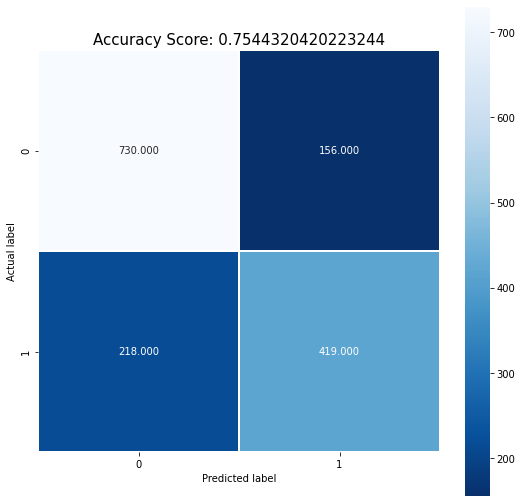

In [74]:
cm = confusion_matrix(y_test, lg_predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

#### CM - Random Forest 

In [0]:
# Make prediction in the test data
rf_predictions = random_forest.predict(X_test)

In [79]:
accuracy = random_forest.score(X_test, y_test)
print("Random Forest - Accuracy: " + str(accuracy))
f1 = f1_score(y_test, rf_predictions, average='macro')
print("Random Forest - F1 Score: "+ str(f1))

Random Forest - Accuracy: 0.7866053841103086
Random Forest - F1 Score: 0.7733739907193107


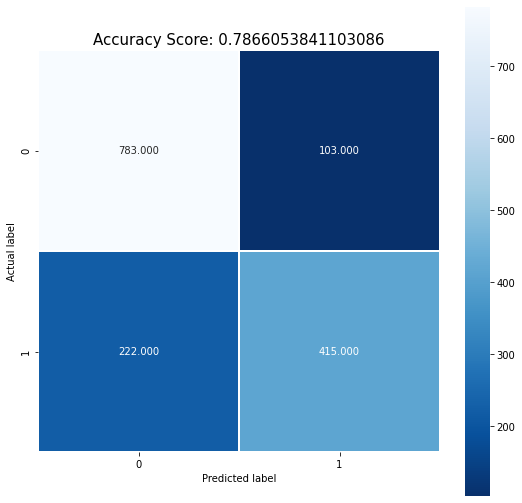

In [80]:
cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

### Submission
Here we prepare the submission file for the competition

In [60]:
example_sub = pd.read_csv('data/sample_submission.csv')
example_sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


We would make our submission with the data vectorized using TF - IF and predicted with the Logic Regression Model.

In [94]:
predictions = logistic_regression.predict(test_data_tfidf)

array([1, 0, 0, ..., 1, 1, 0])

In [96]:
ids = train_data_tfidf.filter(['id'], axis=1)
predictions = pd.DataFrame(predictions, columns=['target'])
submission = pd.concat([ids, predictions], axis=1)
submission.head()

,id,target
0,1,1.0
1,4,0.0
2,5,0.0
3,6,0.0
4,7,0.0


In [0]:
submission.to_csv('submision.csv', index=False)